<a href="https://colab.research.google.com/github/andrebelem/pymhw/blob/main/Test_Marine_Heat_Waves_detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Developing and some ideas

This is the development notebook for extracting Marine Heat Wave (MHW) statistics from sea surface temperature (SST) time series. There is a vast literature on the subject, including the classic work by [Hobday et al., 2018](https://doi.org/10.5670/oceanog.2018.205), although the Python codes provided at that time are outdated compared to the latest advancements.

The idea here is an adaptation of Hobday's concept, differing only in that the climatology can be "external" to the data, which is useful in the case of buoy applications that have gaps, or satellite data without optimal interpolation. A theoretical detail about this is that if the mean SST increases due to warming, but the variability (σ) remains constant, the SST distribution shifts to the right. In this case:
- The absolute value corresponding to the old 90th percentile may now be closer to the mean, causing more days to be classified as MHWs.
- If warming also increases variability (σ), the distribution becomes wider, which can affect the frequency and intensity of MHWs.

Using percentiles to define MHWs is practical but can lead to saturation of the measure with continuous ocean warming if the reference period is not adjusted. It is also important to consider the standard deviation of climatology to capture changes in SST variability, providing a more comprehensive view of MHWs in the context of climate change.

The idea here, therefore, is to calculate the z-score, which is related to Hobday's percentiles as follows:

| Category | Percentile | Z-Score |
|----------|------------|---------|
| 1        | 90%        | 1.28    |
| 2        | 95%        | 1.645   |
| 3        | 98%        | 2.054   |
| 4        | 99%        | 2.33    |

<br><br>
It is also important to note that Hobday suggests measures related to MHW itenit, such as $I$ (intensity), $I_{cum}$, and  $I_{max}$ , in addition to a 30-year climatology and a minimum duration of 5 days, allowing for a maxmumof 2 days of  $I$  drop below the 90th percentile. The challenge here is that buoy data often have gaps, compromising the MHW statistics. The tests below are designed to address these issues and were developed based on a simple sea surface temperature (SST) series from the Tupi Field in the Santos Basin, extract from GHRSST (The product [UKMO-L4HRfnd-GLOB-OSTIA](https://podaac.jpl.nasa.gov/dataset/UKMO-L4HRfnd-GLOB-OSTIA) is coordinated by the Group for High-Resolution Sea Surface Temperature (GHRSST) under what we call L4 (Level 4) and is produced daily on an operational basis at the UK Met Office using optimal interpolation (OI) on a global grid of 0.054 degrees (~5 km)).


In [2]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/andrebelem/1o_curso_ASTOC/main/dados_publicos/tupi_sst_mean.csv',decimal=',',sep=';')
df.time = pd.to_datetime(df.time)
df = df.set_index('time')
# There is not a great need to strictly follow this pattern, but obviously you
# will need to adapt the code below if you want to change (for example) the column names. Here I am using a time series and will create a "gap" for testing.

# Now I will create a gap in 2013 - that is, a total absence of data.
df_gap = df[~df.index.year.isin([2013])]

Note that here, the original data has temporal consistency but with gaps, which hinder the construction of a climatology. Obviously, the two series do not need to be from the same source (in this case, it is GHRSST OSTIA), but the climatology needs to have more *statistical consistency* than the series to be analyzed.


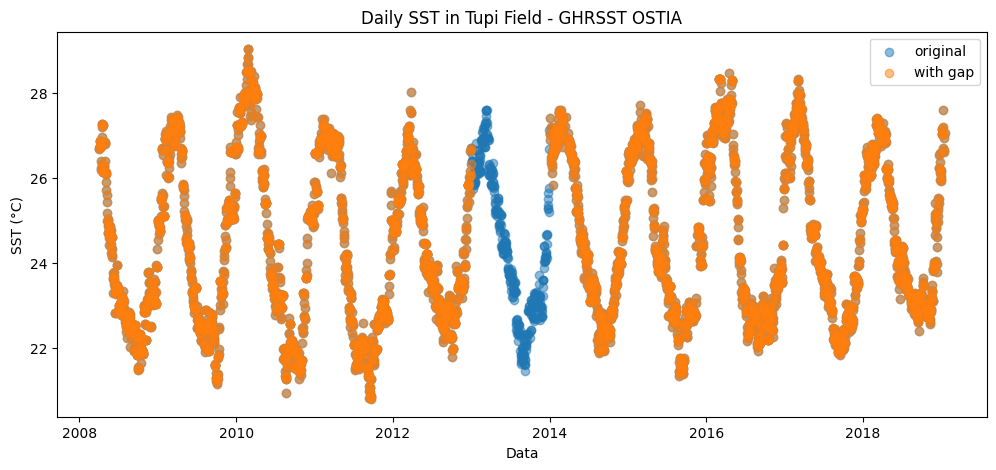

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,5))
plt.scatter(df.index,df.sst,alpha=0.5,label='original')
plt.scatter(df_gap.index,df_gap.sst,alpha=0.5,label='with gap')
plt.xlabel('Data')
plt.ylabel('SST (°C)')
plt.title('Daily SST in Tupi Field - GHRSST OSTIA')
plt.legend()
plt.show()

The strategy is to construct a dataframe that contains the climatology of a known period "before" performing the analysis. Unlike Hobday's code, which built the climatology from the series. This climatology here was constructed (for example) between 2008 and 2013 (5 years) from the original series. Note that we do not distinguish leap years (unlike Hobday). Consider that the climatology should have at least 30 years and **can be based on GHRSST**.


In [5]:
df.index.year # <-- important: your series MUST be time-indexed

Index([2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008,
       ...
       2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019],
      dtype='int32', name='time', length=3876)

In [6]:
# Climatology between 2008 e 2014 "inclusive" **This is a test**
# The climatology must have statistical consistency, and therefore, when it is constructed,
# it MUST have the same number of samples over the 30 years.

# step 1 - limiting my period and stepdown timeindex
clima = df[(df.index.year >= 2008) & (df.index.year <= 2013)].reset_index()

# step 2 - create mean and std grouping by day of year
df_clima =  clima.groupby(clima.time.dt.dayofyear).agg(['mean','std']).iloc[:,[2,3]]

# Note that the result is a climatology that contains "time" (day of year 1-366) and "std" in the index.
# The latter will be used to calculate the z-score and convert it into a percentile.
df_clima

sst          
           mean       std
time                     
1     25.852856  0.872301
2     25.941428  0.995596
3     26.050000  1.173561
4     25.987143  1.083333
5     25.964286  1.112119
...         ...       ...
362   25.345239  1.149124
363   25.382859  1.202322
364   25.659525  1.023365
365   25.922620  1.019910
366   25.857143  1.191983

[366 rows x 2 columns]

In [7]:
df_clima.columns # <--- note this is a multi index column


MultiIndex([('sst', 'mean'),
            ('sst',  'std')],
           )

Now the next step is to apply the climatology to the series and extract the MHWs and their respective indices and parameters.


In [8]:
import pandas as pd
import numpy as np

def detect_MHW(df, df_clima, freq='1D'):
    # Make a copy of the DataFrame to ensure that the original will not be modified.
    df2 = df.copy()
    df2_clima = df_clima.copy()

    # Verify if the index is a DatetimeIndex
    if not isinstance(df2.index, pd.DatetimeIndex):
        try:
            df2.index = pd.to_datetime(df2.index)
        except Exception as e:
            raise ValueError("The index cannot be converted to a DatetimeIndex.") from e

    # Generate an expected regular index based on the provided frequency.
    expected_index = pd.date_range(start=df2.index.min(), end=df2.index.max(), freq=freq)

    # Reindex the DataFrame to ensure it is regular.
    df2 = df2.reindex(expected_index)

    # Some basic statistics:
    # Calculate the time differences between entries in the original index.
    time_diffs = df.index.to_series().diff().dropna()

    # Calculate the mode of the time differences.
    dominant_freq = time_diffs.mode()[0]

    # Compare the dominant frequency with the expected frequency
    expected_freq = pd.Timedelta(freq)
    if dominant_freq != expected_freq:
        raise ValueError(f"The dominant frequency of the data ({dominant_freq}) does not match the expected frequency ({expected_freq}).")

    # Additional statistics
    start_date = df2.index.min()
    end_date = df2.index.max()
    num_points = len(df2)
    num_nans = df2.isna().sum().sum()  # Total number of NaNs
    percent_nans = (num_nans / df2.size) * 100  # Percentage of NaNs

    # Print the statistics
    print(f"Series from {start_date} to {end_date}")
    print(f"Dominant frequency: {dominant_freq}")
    print(f"Number of points: {num_points}")
    print(f"Number of NaNs: {num_nans}")
    print(f"Percentage of NaNs: {percent_nans:.2f}%")

    # Remove the time index and insert dayofyear
    df2 = df2.reset_index().rename(columns={'index':'time'})
    df2['dayofyear'] = df2.time.dt.dayofyear

    # Calculate the anomaly and compare with std
    df2['anomaly'] = df2.apply(lambda row: row['sst'] - df_clima.loc[row['dayofyear'], ('sst', 'mean')], axis=1)
    df2['zscore'] = df2.apply(lambda row: row['anomaly'] / df_clima.loc[row['dayofyear'], ('sst', 'std')], axis=1)

    # Identify periods where the zscore is greater than 1.28 (90%)
    df2['above_90'] = df2['zscore'] > 1.28

    return df2

In [9]:
def calculate_mhw_periods(df2):
    # Define intensity categories based on z-score thresholds
    categories = [
        (1, 1.28),
        (2, 1.645),
        (3, 2.054),
        (4, 2.33)
    ]

    mhw_periods_list = []

    for category, threshold in categories:
        df2['above_threshold'] = df2['zscore'] > threshold

        # Identify the durations of periods where the zscore is greater than the threshold
        df2['mhw_id'] = (df2['above_threshold'] != df2['above_threshold'].shift()).cumsum()
        mhw_periods = df2[df2['above_threshold']].groupby('mhw_id').agg(
            start=('time', 'min'),
            end=('time', 'max'),
            duration=('time', 'count'),
            max_zscore=('zscore', 'max'),
            cum_zscore=('zscore', 'sum')
        ).reset_index(drop=True)

        # Filter out periods with duration less than or equal to 5 days
        mhw_periods = mhw_periods[mhw_periods['duration'] > 5]

        # Assign the category to the mhw_periods
        mhw_periods['category'] = category

        mhw_periods_list.append(mhw_periods)

    # Concatenate all mhw_periods into a single dataframe
    mhw_periods_all = pd.concat(mhw_periods_list, ignore_index=True)

    # Rename max_zscore to I_max and cum_zscore to I_cum for each MHW period
    mhw_periods_all = mhw_periods_all.rename(columns={'max_zscore': 'I_max', 'cum_zscore': 'I_cum'})

    return mhw_periods_all

Let's execute this code ...

In [11]:
df_temp = detect_MHW(df,df_clima)

Series from 2008-04-02 00:00:00 to 2019-01-16 00:00:00
Dominant frequency: 1 days 00:00:00
Number of points: 3942
Number of NaNs: 66
Percentage of NaNs: 1.67%


In [12]:
mhw = calculate_mhw_periods(df_temp)
mhw

,start,end,duration,I_max,I_cum,category
0,2009-11-03,2009-11-29,27,1.942818,46.549727,1
1,2009-12-03,2009-12-09,7,1.695642,11.143071,1
2,2010-01-10,2010-01-20,11,1.672260,17.454598,1
3,2010-02-09,2010-03-08,28,1.729541,44.320430,1
4,2010-03-11,2010-03-23,13,1.733900,21.304027,1
5,2010-03-28,2010-04-02,6,1.501984,8.352464,1
6,2010-04-04,2010-04-11,8,1.670665,12.278246,1
7,2010-05-07,2010-05-19,13,1.932171,21.632980,1
8,2010-07-14,2010-07-19,6,1.746794,9.221314,1
9,2013-06-12,2013-06-18,7,1.660244,10.607288,1


Now testing some graphics

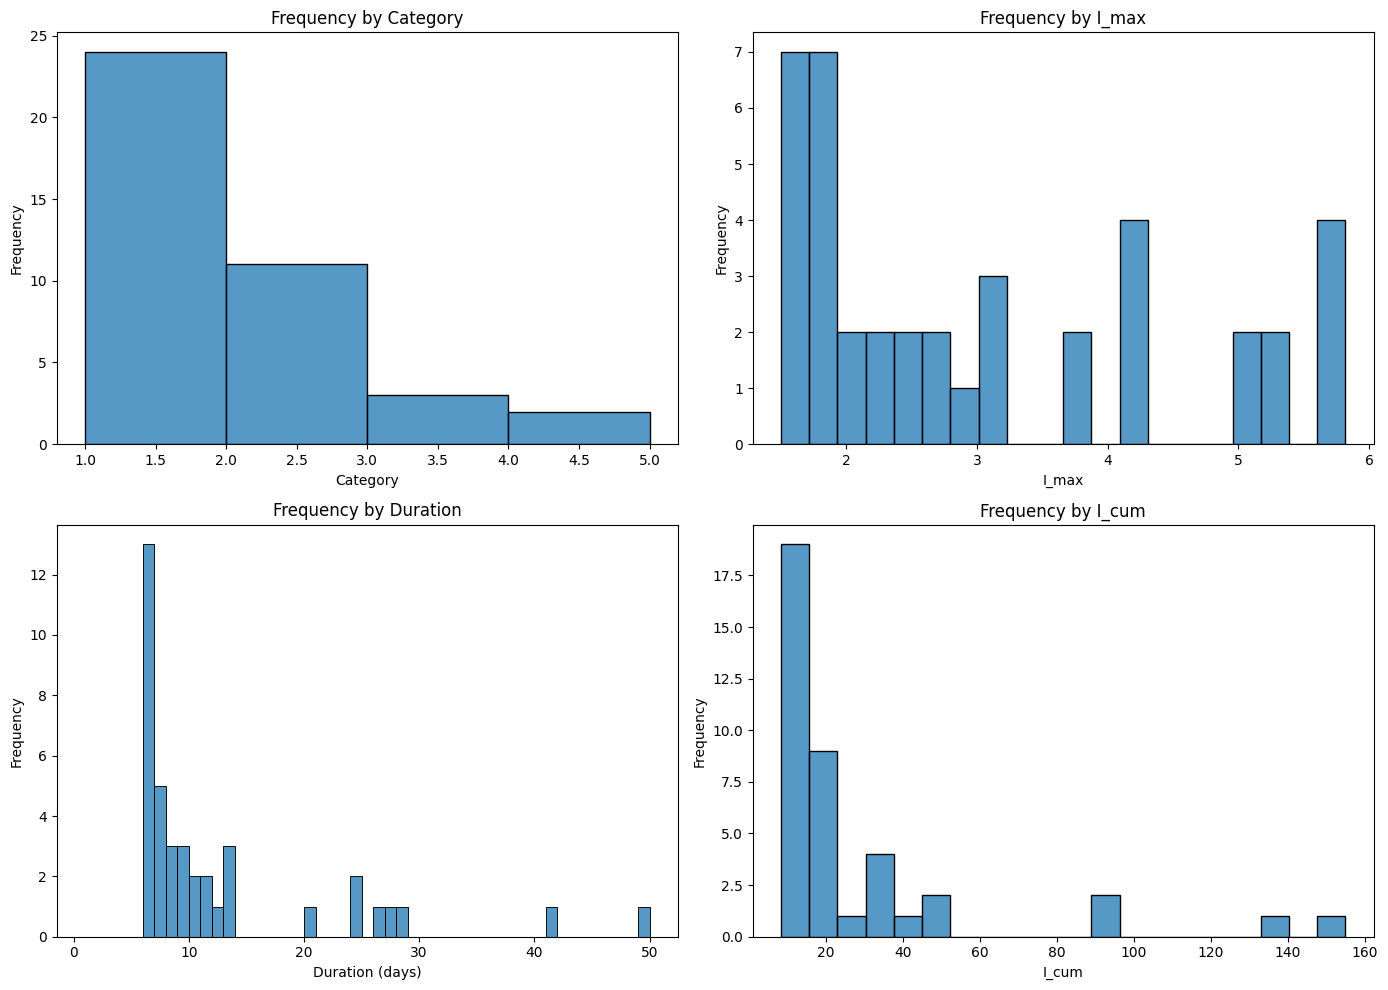

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Previous functions here...

# Assuming df and df_clima are your already loaded DataFrames
# df_temp = detect_MHW(df, df_clima)
# mhw = calculate_mhw_periods(df_temp)

# Create combined histograms
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

# Histogram of frequency by category
sns.histplot(mhw['category'], bins=range(1, mhw['category'].max() + 2), kde=False, ax=ax[0, 0])
ax[0, 0].set_title('Frequency by Category')
ax[0, 0].set_xlabel('Category')
ax[0, 0].set_ylabel('Frequency')

# Histogram of frequency by I_max
sns.histplot(mhw['I_max'], bins=20, kde=False, ax=ax[0, 1])
ax[0, 1].set_title('Frequency by I_max')
ax[0, 1].set_xlabel('I_max')
ax[0, 1].set_ylabel('Frequency')

# Histogram of frequency by duration
sns.histplot(mhw['duration'], bins=range(1, mhw['duration'].max() + 2), kde=False, ax=ax[1, 0])
ax[1, 0].set_title('Frequency by Duration')
ax[1, 0].set_xlabel('Duration (days)')
ax[1, 0].set_ylabel('Frequency')

# Histogram of frequency by I_cum
sns.histplot(mhw['I_cum'], bins=20, kde=False, ax=ax[1, 1])
ax[1, 1].set_title('Frequency by I_cum')
ax[1, 1].set_xlabel('I_cum')
ax[1, 1].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()



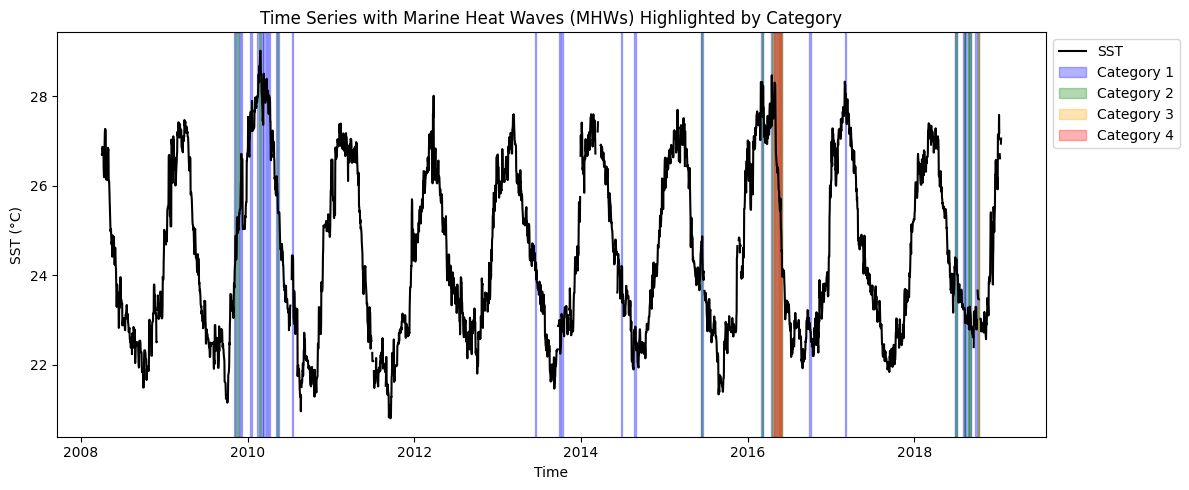

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming previous functions are defined and mhw is calculated
# df_temp = detect_MHW(df, df_clima)
# mhw = calculate_mhw_periods(df_temp)

# Create a color map for the categories
category_colors = {
    1: 'blue',
    2: 'green',
    3: 'orange',
    4: 'red'
}

# Plot the time series and mark MHWs
fig, ax = plt.subplots(figsize=(12, 5))

# Plot the SST time series
ax.plot(df_temp['time'], df_temp['sst'], label='SST', color='black')

# Highlight MHWs with different colors based on category
for _, row in mhw.iterrows():
    start = row['start']
    end = row['end']
    category = row['category']
    ax.axvspan(start, end, color=category_colors[category], alpha=0.3, label=f'Category {category}')

# Add labels and title
ax.set_xlabel('Time')
ax.set_ylabel('SST (°C)')
ax.set_title('Time Series with Marine Heat Waves (MHWs) Highlighted by Category')

# Create a custom legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
# Place the legend outside the plot
ax.legend(by_label.values(), by_label.keys(), loc='upper left', bbox_to_anchor=(1, 1))

# Show plot
plt.tight_layout()
plt.show()


## Conclusion

This analysis provides a comprehensive overview of Marine Heat Waves (MHWs) within the observed sea surface temperature (SST) time series. By utilizing z-scores and percentile-based thresholds, we were able to categorize MHWs into four distinct categories, each reflecting different levels of intensity based on the maximum z-score ($I_{max}$) and cumulative z-score ($I_{cum}$).

![](https://i.pinimg.com/originals/c3/68/d1/c368d1963574e75c9226faf041054e69.gif)
